In [1]:
rootF = 'D:/Data/Paper defocus/'

In [2]:
import numpy as np
import skimage
import skimage.io
import os
import pandas as pd
import fnmatch
import skimage.transform
from matplotlib.pyplot import *

# Import functions
from shared.functions import fit_gaussian, get_ellipse_parameters, plot_scale_bar, load_image_as_on_MEA
from shared.save_load import load_obj, save_obj
from shared.LSC_functions import local_spatial_contrast

In [39]:
# Experiment
exp = 20211207

# Load data

## Spike data

In [40]:
spike_times = np.load(rootF + '/MEA/exp' + str(exp) + '/sorting/spike_times.npy')

spike_clusters = np.load(rootF + '/MEA/exp' + str(exp) + '/sorting/spike_clusters.npy')  

import csv as csv
cgf = open(rootF + '/MEA/exp' + str(exp) + '/sorting//cluster_group.tsv')  
cgfr = csv.reader(cgf,delimiter="\t") 
cluster_group = dict()
next(cgfr)
for row in cgfr:
    cluster_group[row[0]]=row[1]
    
Clusters = np.array(list(cluster_group.keys()),dtype='int')

print (len(Clusters), 'clusters')

332 clusters


### Selected cells

In [41]:
# Load the list of selected cells based on STA and response to chirp

results_path = rootF + '/MEA/exp' + str(exp) + '/'
    
cluster_selection = pd.read_excel(results_path + str(exp) + '_cluster_selection.xlsx', header=0)

cluster_names = cluster_selection['Cluster']

good_cells = cluster_names

print (len(good_cells), 'good cells!')

132 good cells!


### Build the response (sharp images)

In [42]:
Mtimes = []
Trigs = []

fs=20000

nmeas = 5
time_elapsed = 0

measAll= np.arange(10)+1

for measnum in np.arange(nmeas):
    meas=measAll[measnum]
    rootF_data = rootF + '/MEA/exp' + str(exp) + '/triggers/'
    trigs,ttot= load_obj(rootF_data + 'exp' + str(exp) + '-meas_0' + str(meas) + '_triggers_unfilt')
    
    Trigs.append(time_elapsed+trigs/fs)
    Mtimes.append(time_elapsed)
    print (time_elapsed)
    
    time_elapsed+=ttot
Mtimes.append(time_elapsed)
time_elapsed

0
2619.0
3740.2
4551.3
11395.7


15195.7

## Ellipses

In [43]:
# Load ellipse points within the 2sigma contour
ell_path = rootF + '/contrast analysis/ellipses_data_with_weights_2sigma_' + str(exp) 

ellipse_data_2s = load_obj(ell_path + '.pkl')

# Measure LSC

### OFF slow and ON-OFF local cells

From previous codes

Cell 558 (ON-OFF local) removed because bad STA fitting

### ON alpha cells

Cells removed because of bad STA fitting:

20211208 cell 424

In [44]:
if exp == 20211129:
    selected_cells = [1, 258, 404, 406, 433, 604] # skip_cells = [45, 80, 188, 192, 401, 408, 422, 525, 533, 558, 561, 614, 682]
elif exp == 20211207:
    selected_cells = [77, 129, 184, 217, 229, 246, 310, 381, 393, 396, 405, 418, 458, 472, 476, 479, 491, 498] #skip_cells = [33, 52, 145, 302, 340, 406, 414, 515]
elif exp == 20211208:
    selected_cells = [273, 435, 449, 463, 513] # skip_cells = [99,100,276,407,424,452, 472,498] 

In [45]:
if exp == 20211207 or exp == 20230209:
    meas = 4
else:
    meas = 3

print (meas)

stim_index = meas - 1 

scaling_factor = 8

#-----------------
# Get start times and make rasters
#-----------
# Get stim trials

if xps:
    stimF = 'F:/MEA data/stimulations/fipwfc_20211123_convolved_288elements/fi_merge/'
    imageF = 'F:/MEA data/stimulations/fipwfc_20211123_convolved_288elements/fi/'
else:
    stimF = '/mnt/ad978934-bc32-4a32-abbf-287b415f9e41/MEA data/stimulations/fipwfc_20211123_convolved_288elements/fi_merge/'
    imageF = '/mnt/ad978934-bc32-4a32-abbf-287b415f9e41/MEA data/stimulations/fipwfc_20211123_convolved_288elements/fi/'
    
stim_trials_f = open(stimF + 'fi_merge_fi_trials.csv') # file that contains the condition number, the start and end of the display
stim_trials_f = csv.reader(stim_trials_f,delimiter=",")

stim_trials=[]
for row in stim_trials_f:
    stim_trials.append(np.array(row))

stim_trials_head = stim_trials[0]
stim_trials = np.array(stim_trials[1:]).astype(float)
print('STIM TRIALS:', stim_trials_head)

# Convert to times with trigtimes
trigs = Trigs[stim_index]

for st in stim_trials:
    st[2]=trigs[int(st[2])]
    st[3]=trigs[int(st[3])+1]

# Get images
stim_images_f = open(imageF + 'fi_conditions.csv')
stim_images_f = csv.reader(stim_images_f,delimiter=",")

mean_intensities = []
local_contrasts = []

c=0
stim_images = []
for row in stim_images_f:
    if c==0:
        stim_images_head = row # condition, corresponding image name
        c=1
    else:
        stim_images.append(row)
        image = imread(os.path.join(imageF, row[1]))         
        rotated_image = np.rot90(image)
        im = np.flipud(rotated_image)

        mean_ints = []
        loc_contr = []
        loc_contr05 = []
        for iCell, cell_nb in enumerate(selected_cells):
            ### Get ellipse points
            ellipsepoints = ellipse_data_2s[cell_nb]['ellipse_points']
            weights = ellipse_data_2s[cell_nb]['weights']
            ellipseweights = weights[ellipsepoints[:,1], ellipsepoints[:,0]]

            ### Mean intensity, LSC
            i_mean, lsc = local_spatial_contrast(im, ellipse_points=ellipsepoints, ellipse_weights=ellipseweights)
            mean_ints.append(i_mean)
            loc_contr.append(lsc)

        mean_intensities.append(mean_ints)
        local_contrasts.append(loc_contr)

print('STIM IMAGES:', stim_images_head)

4
STIM TRIALS: ['' 'condition_nb' 'start_display_nb' 'end_display_nb']
STIM IMAGES: ['', 'path']


# Get spikes associated with each image and create training and testing sets

In [46]:
# Get images start times and their condition
im_starts=[]
for stim in stim_trials:
    condition = int(stim[1]) # images number
    start = stim[2] # start time of image presentation
    im_starts.append((condition, start))
im_starts = np.array(im_starts)
print ('Images times:', im_starts.shape)

Images times: (4060, 2)


In [47]:
frate = 40

responses = np.zeros((len(good_cells), len(im_starts), 2 )) # response of each cell to each image

for n,i in enumerate(good_cells):
    print (n,i)
    
    clus = i
    
    #Get spike_times
    sp_times = spike_times[spike_clusters == int(clus)]/fs
    print('Nspikes: ', len(sp_times))

    stim_sptimes = sp_times[(sp_times>Mtimes[stim_index]) & (sp_times<Mtimes[stim_index+1])]

    print('sptimes in stim: ', len(stim_sptimes), '   % spikes: ' , round(len(stim_sptimes)/len(sp_times)*100,1))
    
    # Get start times and make rasters
    for y,trial in enumerate(im_starts):
        responses[n,y]=(int(trial[0]), len(stim_sptimes[(trial[1]+0.05<stim_sptimes)&(stim_sptimes<trial[1]+0.35)])) # trial[0] is the condition

0 6
Nspikes:  45987
sptimes in stim:  17055    % spikes:  37.1
1 26
Nspikes:  387869
sptimes in stim:  179320    % spikes:  46.2
2 33
Nspikes:  86664
sptimes in stim:  33925    % spikes:  39.1
3 41
Nspikes:  50537
sptimes in stim:  22903    % spikes:  45.3
4 44
Nspikes:  22263
sptimes in stim:  9138    % spikes:  41.0
5 45
Nspikes:  52450
sptimes in stim:  24872    % spikes:  47.4
6 52
Nspikes:  72660
sptimes in stim:  33325    % spikes:  45.9
7 59
Nspikes:  91936
sptimes in stim:  36681    % spikes:  39.9
8 60
Nspikes:  31953
sptimes in stim:  6522    % spikes:  20.4
9 61
Nspikes:  45083
sptimes in stim:  21454    % spikes:  47.6
10 63
Nspikes:  21651
sptimes in stim:  10276    % spikes:  47.5
11 64
Nspikes:  12820
sptimes in stim:  2753    % spikes:  21.5
12 65
Nspikes:  18629
sptimes in stim:  7754    % spikes:  41.6
13 69
Nspikes:  98957
sptimes in stim:  41653    % spikes:  42.1
14 74
Nspikes:  106822
sptimes in stim:  56566    % spikes:  53.0
15 77
Nspikes:  104142
sptimes in sti

In [48]:
print(responses.shape)  #for each cell this should have the number of spikes that this cell fired for each of the 4060 images
# that were presented to it
# and the number of condition that identifies the image
# responses[0,7] is the response that the 0th cell in goodcels gave to the condition presented 7th that is also reported
# why 4060? 3190 where the images but 30 where repeated 30 times

print (len(stim_images))
print (len(local_contrasts))

(132, 4060, 2)
3190
3190


### Create training and testing set 

In [49]:
trial_freq = np.zeros((3190))

for stim in stim_trials:
    condition = int(stim[1])
    trial_freq[condition]+=1    #this variable contains the frequencies with which the conditions (images) were shown

training_indices = np.where(trial_freq == 1)[0]

# Testing
test_indices= np.where(trial_freq > 1)[0] # the trials in the testing set

# Check that there is no overlap
for i in test_indices:
    if i in training_indices:
        print('Error in the indexes choice')

In [50]:
print(test_indices)
print(training_indices)

[   3   23  168  197  199  258  335  341  856  946  975 1021 1080 1113
 1158 1196 1237 1248 1425 1689 1933 2183 2198 2225 2248 2272 2371 2778
 2989 3144]
[   0    1    2 ... 3187 3188 3189]


#### Training set

In [51]:
mean_intensities = np.array(mean_intensities)
local_contrasts = np.array(local_contrasts)
image_names = np.array([stim_images[i][1][7:] for i in range(len(stim_images))])

print (mean_intensities.shape)
print (image_names.shape)
print (image_names[:3])

(3190, 18)
(3190,)
['image_0001.png' 'image_0003.png' 'image_0004.png']


In [52]:
intensities_train = []
contrast_train = []
images_names_train = []
responses_train = np.zeros((len(training_indices),len(good_cells)))
for i,idx in enumerate(training_indices):
    intensities_train.append(mean_intensities[idx])
    contrast_train.append(local_contrasts[idx])
    images_names_train.append(image_names[idx])
    for cell in range(len(good_cells)):
        responses_train[i,cell] = responses[cell,np.where(responses[cell,:,0]==idx)[0][0],1]
intensities_train = np.array(intensities_train)
contrast_train = np.array(contrast_train)
images_names_train = np.array(images_names_train)

responses_train.shape

(3160, 132)

#### Test set

In [53]:
intensities_test = []
contrast_test = []
image_names_test = []
responses_test = np.zeros((int(trial_freq[test_indices[0]]), len(test_indices),len(good_cells)))

for j,idx in enumerate(test_indices): # loop on the 30 different repeated images
    intensities_test.append(mean_intensities[idx])
    contrast_test.append(local_contrasts[idx])
    image_names_test.append(image_names[idx])
    for cell in range(len(good_cells)):
        idx_cond = np.where(responses[cell,:,0]==idx)[0] # search for indices of repetitions
        responses_test[:,j,cell] = responses[cell,idx_cond,1]
intensities_test = np.array(intensities_test)
contrast_test = np.array(contrast_test)
image_names_test = np.array(image_names_test)

print (image_names_test)

['image_0005.png' 'image_0031.png' 'image_0255.png' 'image_0295.png'
 'image_0297.png' 'image_0373.png' 'image_0475.png' 'image_0482.png'
 'image_1057.png' 'image_1175.png' 'image_1210.png' 'image_1266.png'
 'image_1346.png' 'image_1388.png' 'image_1466.png' 'image_1562.png'
 'image_1617.png' 'image_1635.png' 'image_1894.png' 'image_2219.png'
 'image_2470.png' 'image_2845.png' 'image_2881.png' 'image_2955.png'
 'image_2997.png' 'image_3031.png' 'image_3198.png' 'image_3794.png'
 'image_4012.png' 'image_4167.png']


# Sanity check

77 77


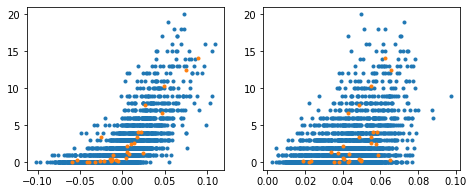

129 129


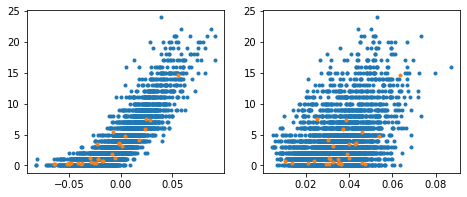

184 184


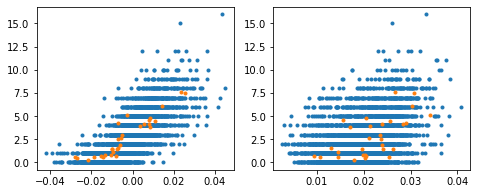

217 217


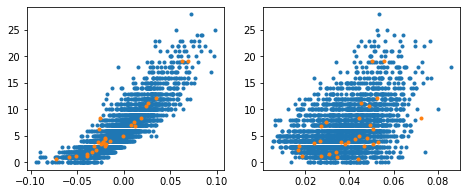

229 229


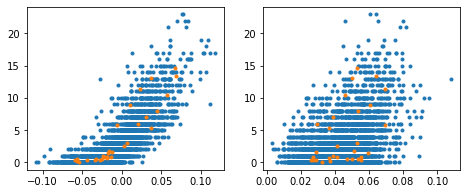

246 246


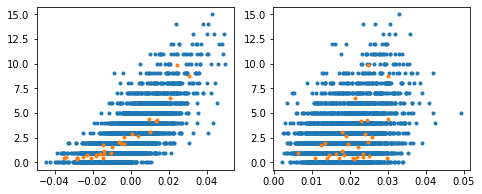

310 310


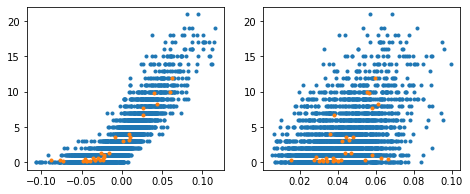

381 381


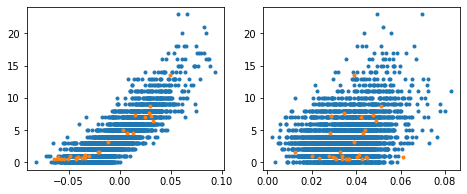

393 393


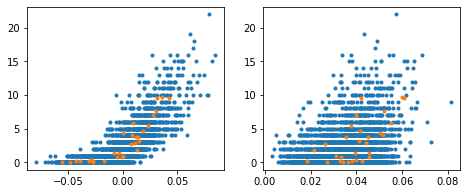

396 396


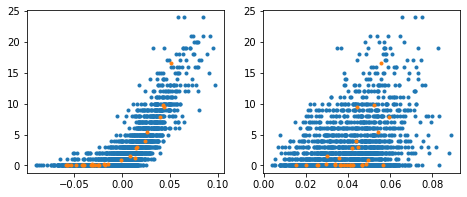

405 405


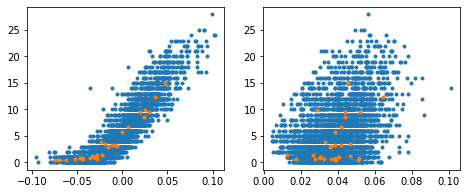

418 418


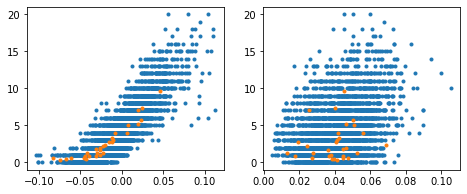

458 458


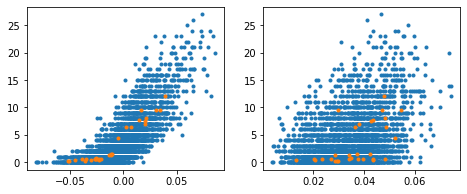

472 472


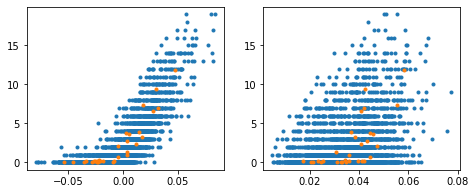

476 476


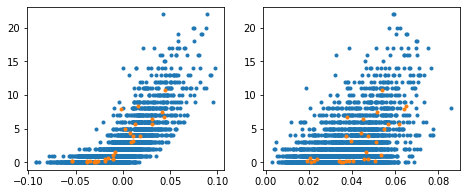

479 479


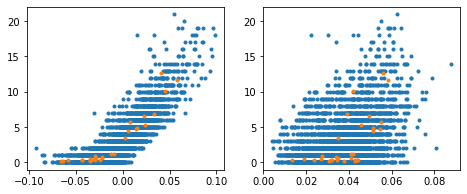

491 491


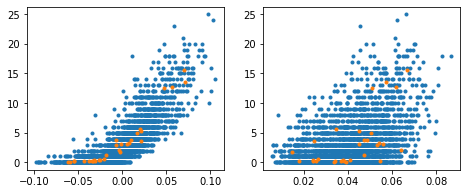

498 498


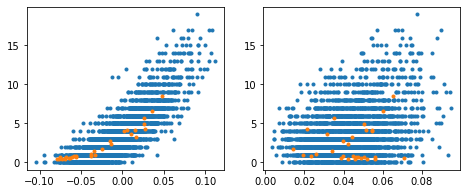

In [54]:
for iCell, cell_nb in enumerate(selected_cells):
    index = np.where(good_cells == cell_nb)[0][0]
    print (cell_nb, good_cells[index])
    figure(figsize=(12, 3))
    subplot(131)
    plot(intensities_train[:, iCell], responses_train[:, index], '.')
    plot(intensities_test[:, iCell], np.mean(responses_test[:, :, index], axis=0), '.')
    subplot(132)
    plot(contrast_train[:, iCell], responses_train[:, index], '.')
    plot(contrast_test[:, iCell], np.mean(responses_test[:, :, index], axis=0), '.')
    show()


In [55]:
# Save this selection

output_folder = rootF + '/MEA/exp' + str(exp) + '/'
 
np.savez(output_folder + str(exp) + '_liu_2022_data_ON_alpha.npz', \
      clusters = good_cells, images_train = images_names_train, images_test = image_names_test, \
      spike_count_train = responses_train, intensities_train = intensities_train, \
      contrast_train = contrast_train, \
      spike_count_test = responses_test, intensities_test = intensities_test, \
      contrast_test = contrast_test)